# Predicting uncertainty with (deep) neural networks

### Experiment Description
The aim of this experiment is to execute an initial validation of the idea/technique proposed by Steve Thron in [1]. The purpose of this notebook is twofold: First, we will try to validate that **the correct execution of the source code, so we can consider idea/experiment as reproducible** as we get exactly the same results. Secondly, we would like to execute a rudimentary test to **check if this idea doesn't degrade the original network inference output** in terms of accuracy

**Original Idea**
The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function

**References**

[1] https://medium.com/@steve_thorn/predicting-uncertainty-with-neural-networks-aec0217eb37d

[2] https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb

### Questions

> **(1)** Can we reproduce the same experiment results under the same conditions? 

> **(2)** Does the network performance vary adding an extra output (variance) that depends on the target? 

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline

## Utilities

#### Custom loss function

In [2]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

#### Model definition

In [3]:
# Here, parameters are common for all experiments
input_size = 1
output_size = 2
hidden_size = 1000

# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
class TwoLayer_Network(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayer_Network, self).__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        linear_1 = self.l1(x)
        h_relu = self.relu(linear_1)
        y_pred = self.l3(h_relu)
        return y_pred

#### Prepare data for training

In [4]:
def data_preparation(x, y, n_validation=500):
    # Add in column of dummy zeros to represent sigma 
    sigma = np.zeros(y.size)
    y = np.stack([y, sigma], axis=1)
    x = x.reshape(x.size, 1)
    
    # Split into training and validation sets
    x_val, x = x[:n_validation], x[n_validation:]
    y_val, y = y[:n_validation], y[n_validation:]
    
    return  x_val, x,  y_val, y

#### Visualization utilities

In [5]:
def plot_regression_dataset(x, y, y_1, title_txt):   
    # Plot the data
    plt.figure(figsize=(14,6))
    plt.title(title_txt)

    plt.plot(x, y_1, '.', alpha=0.2, color='black' ) 
    plt.plot(x, y, '.', alpha=0.2, color='green' ) 

    plt.xlabel(r'$x$');
    plt.ylabel(r'$y$');
    plt.show()

In [6]:
def plot_regression_uncertainty(x_val, y_val, y_pred, sigma_pred):  
    # Plot predictions and their errors
    fig, ax1 = plt.subplots(figsize=(14,6))
    plt.title('Estimated uncertainty in predictions')

    ax1.plot(x_val, y_val[:,0], '.', color='purple')
    ax1.errorbar(x_val, y_pred, yerr=np.sqrt(sigma_pred) , color='green', fmt='.'); 

    # One standard-deviation envelope
    plt.xlabel(r'$x$');
    plt.ylabel(r'$y$');
    plt.title('Validation set predictions');
    plt.legend([r'Original data', 'Predicted sigma in predictions', 'Real sigma in predictions'], loc='upper left', );

## Synthetic Dataset

#### Generate the synthetic data

In [7]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

#### Describe the generated data

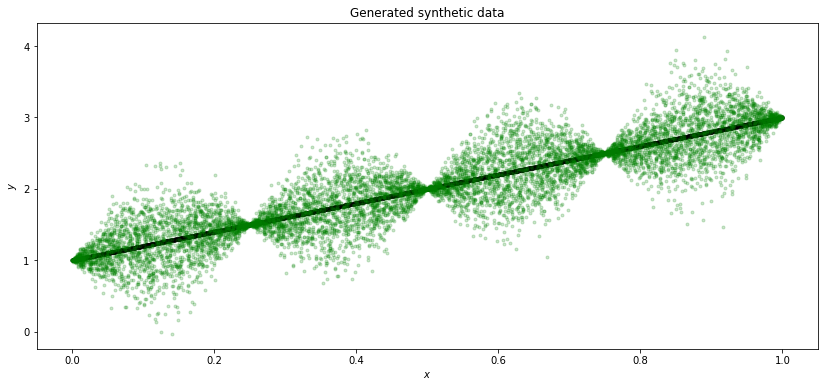

In [8]:
# Plot the data
plot_regression_dataset(x, y, y_1, 'Generated synthetic data')

In [9]:
x_val, x,  y_val, y = data_preparation(x, y, n_validation=500)

#### Prepare the dataset and split in train and test

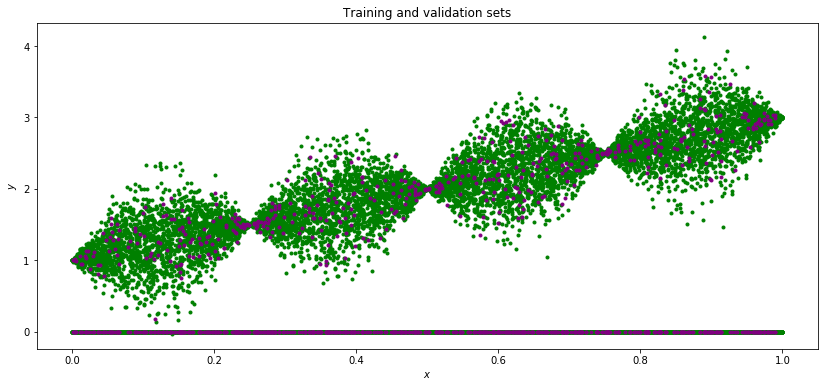

In [10]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [11]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Original Experiment - Question 1

> **(1)** Can we reproduce the same experiment results under the same conditions? 

#### Create a simple network 

In [54]:
model_1 = TwoLayer_Network(input_size, hidden_size, output_size).cuda()

In [55]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

#### Training loop 
We train this simple model with batch size equal to the whole dataset. Here, we use 'loss_variance_error' function

In [56]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 15.6
epoch:  500 loss: 0.0551
epoch: 1000 loss: 0.054
epoch: 1500 loss: 0.0538
epoch: 2000 loss: 0.0537
epoch: 2500 loss: 0.0535
epoch: 3000 loss: 0.0535
epoch: 3500 loss: 0.0534
epoch: 4000 loss: 0.0533
epoch: 4500 loss: 0.0532
epoch: 5000 loss: 0.0531
epoch: 5500 loss: 0.053
epoch: 6000 loss: 0.0529
epoch: 6500 loss: 0.0528
epoch: 7000 loss: 0.0527
epoch: 7500 loss: 0.0526
epoch: 8000 loss: 0.0525
epoch: 8500 loss: 0.0524
epoch: 9000 loss: 0.0523
epoch: 9500 loss: 0.0522


#### Get predictions for validation set 

In [57]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)
# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

C:\Users\yolan\Anaconda3\envs\deep_learning_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


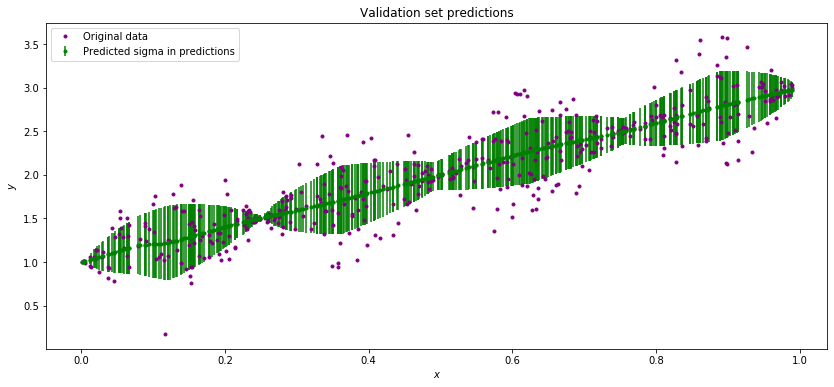

In [58]:
plot_regression_uncertainty(x_val, y_val, y_pred_1, sigma_pred_1)

#### Conclusions

We have validated that we can reproduce the same experiment

### Validation Experiment - Question 2  

> **(2)** Does the network performance vary adding an extra output (variance) that depends on the target? 

#### Create a simple network 

In [27]:
model_2 = TwoLayer_Network(input_size=1, hidden_size=1000, output_size=1).cuda()
# Adam optimizer
learning_rate = 1e-4
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

In [48]:
y = y_t[:,0].reshape(-1,1) # remove variance extra output

In [49]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred_2 = model_2(x_t)
    
    # Calculate loss
    loss_original = F.mse_loss(y_pred_2, y)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss_original.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer_2.zero_grad()
    loss_original.backward()

    # Update parameters
    optimizer_2.step()

epoch:    0 loss: 0.423
epoch:  500 loss: 0.0833
epoch: 1000 loss: 0.0832
epoch: 1500 loss: 0.0832
epoch: 2000 loss: 0.0832
epoch: 2500 loss: 0.0832
epoch: 3000 loss: 0.0832
epoch: 3500 loss: 0.0832
epoch: 4000 loss: 0.0832
epoch: 4500 loss: 0.0832
epoch: 5000 loss: 0.0832
epoch: 5500 loss: 0.0831
epoch: 6000 loss: 0.0831
epoch: 6500 loss: 0.0831
epoch: 7000 loss: 0.0831
epoch: 7500 loss: 0.0831
epoch: 8000 loss: 0.0831
epoch: 8500 loss: 0.0831
epoch: 9000 loss: 0.0831
epoch: 9500 loss: 0.0831


In [50]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_2 = model_2(x_val_t)
# prediction of the response variables
y_pred_2 = pred_2.cpu().data

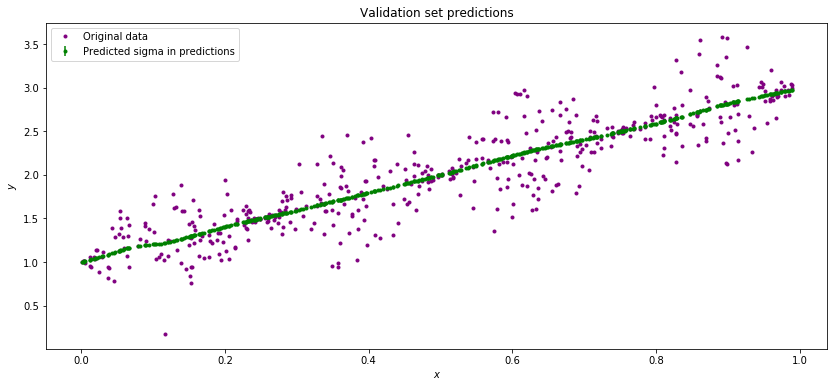

In [51]:
plot_regression_uncertainty(x_val, y_val, y_pred_2, sigma_pred=0)

#### Compute validation metrics of both 

Here, we compute the R2 score for both models:
    * (1) It is the model using an extra output for predicting the prediction variance --> y_pred_1
    * (2) It is the model without an extra output. We only train the net to predict y --> y_pred_2

In [59]:
m.r2_score(y_val[:,0], y_pred_1) # Predicting the variance

0.8010389661116034

In [52]:
m.r2_score(y_val[:,0],y_pred_2) # Without variance

0.8008207215130424

#### Conclusions

The score training of the model with variance is 0.801 and training without variance is 0.80082. We can conclude that adding an extra output to the network doesn't degrade the performance of the original net

### Final Conclusions

* We have validated that we can reproduce the same experiment
* Adding an extra output to the network doesn't degrage the performance of the original net (the net without predicting the variance)